# Setup

Impedance is resistance + complex reactance

$$Z = R + jX$$

| symbol | Name |formula |
|----|----|---|
$Y$ | admittance  (inverse impedance) | $Z^{-1} = Y =  G + jB$ |
$B$ | susceptance |
$G$ |s conductance (real part of admittance)|
$Z$ | impedance |  $Z = R + jX$ |
$X$ |Reactance | 
$R$ | Resistance |
$S$ | Real powerflow approximation from bus 1 to bus 2 in a DC model | $S=\frac{\theta_1 - \theta_2}{-{BR}_X}$ |
$S$ | Real powerflow approximation constraint |$|S| \leq \text{Rate}_A$ |


In [1]:
import psst
from psst.case import read_matpower
from psst.network import create_network
import pandas as pd



cases = """case1888rte
case1951rte
case2848rte
case3012wp
case3375wp
case6468rte
case6470rte
case6495rte
case6515rte""".split('\n')

from IPython.display import display, Markdown
matpower = {}
scuc = {}
network = {}

## Manipulating a small case

None

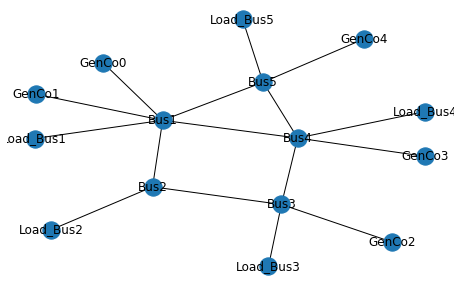

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import psst,os
from psst.case import read_matpower
from psst.model import build_model
from psst.network import create_network
casedir = 'matpower/data'
case5 = read_matpower(os.path.join(casedir,'case5.m'))
generator_df = pd.merge(case5.gen, case5.gencost, left_index=True, right_index=True)
network5 = create_network( case5, prog='neato')
display(network5.draw())
plt.savefig('case5.png')

In [15]:
generator_df.loc['GenCo0','PMIN'] = -10
generator_df.loc['GenCo3','PMIN'] = -10
buses = generator_df[generator_df['PMIN']<0][['GEN_BUS', 'PMIN']].set_index('GEN_BUS')
case5.load[buses.index] = case5.load[buses.index] - buses['PMIN']
case5.load

,Bus1,Bus2,Bus3,Bus4,Bus5
0,10.0,300.0,300.0,410.0,0.0


In [17]:
try:
    model5pmin = build_model(case5, generator_df)
except ValueError as e:
    print(e)

ERROR:pyomo.core:Constructing component 'ComputeProductionCosts' from data=None failed:
ValueError: 'ComputeProductionCosts[GenCo0,0]' does not have a list of domain points that is non-decreasing


Changed model.MinimumPowerOutput to use within=Reals
ERROR: Constructing component 'ComputeProductionCosts' from data=None failed:
    ValueError: 'ComputeProductionCosts[GenCo0,0]' does not have a list of
    domain points that is non-decreasing
'ComputeProductionCosts[GenCo0,0]' does not have a list of domain points that is non-decreasing


# Case 7 (with timepoints)

None

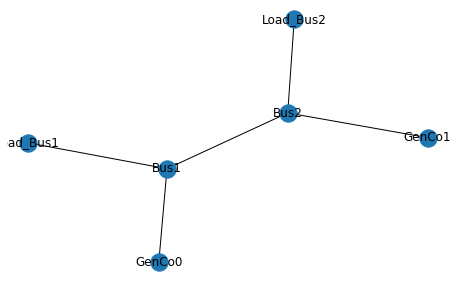

In [131]:
casedir = '../PSST/psst/docs/notebooks/cases'
case7 = read_matpower(os.path.join(casedir,'case7.m'))
generator_df = pd.merge(case7.gen, case7.gencost, left_index=True, right_index=True)
case7.load = pd.read_csv(os.path.join(casedir,'case7.csv'), index_col=0)
network7 = create_network( case7, prog='neato')
display(network7.draw())
plt.savefig('case7.png')

In [23]:
from IPython.display import HTML
HTML(generator_df[['PMIN','PMAX']].to_html().replace('\n',''))

,PMIN,PMAX
GenCo0,0,200
GenCo1,0,500


In [29]:
neg_pmin = case7.gen['PMIN']<0
buses = case7.gen[neg_pmin][['GEN_BUS', 'PMIN']].set_index('GEN_BUS')
buses

,PMIN
GEN_BUS,


## Which Matpower cases are readable?  Which are convertable to a UC model?

In [47]:

casedir = 'matpower/data'
generator = {}
casefile = 'case3012wp'
case = read_matpower(os.path.join(casedir, casefile + '.m' ))
case.gen[case.gen['PMAX'] == 0]

,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME
GenCo496,Bus3006,0.0,-16.02,Inf,-Inf,1.04526,482.3,1,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0
GenCo497,Bus3007,0.0,28.11,Inf,-Inf,1.08868,7776.9,1,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0
GenCo498,Bus3008,0.0,15.62,Inf,-Inf,1.03223,22373.8,1,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0
GenCo499,Bus3010,0.0,29.77,Inf,-Inf,1.05000,33044.7,1,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0
GenCo500,Bus3011,0.0,74.75,Inf,-Inf,1.11000,7212.2,1,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0
GenCo501,Bus3012,0.0,-133.32,Inf,-Inf,1.03018,15218.9,1,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0


In [49]:
len(case.gen_name)

502

In [38]:
case.load[buses.index] = case5.load[buses.index] - buses['PMIN']

,Bus973
0,0.0


In [20]:

import psst, os
from psst.case import read_matpower
from psst.model import build_model
casedir = 'matpower/data'
generator = {}
for casefile in cases:
    #if casefile[-2:] == '.m':
        try:
            case = read_matpower(os.path.join(casedir, casefile + '.m'))
            generator[casefile] = pd.merge(case.gen, case.gencost, left_index=True, right_index=True)
            print(casefile)
            display(generator[(generator_df['PG'] <0) & (generator_df['PMIN'] <0)])
        except:
            print('Could not parse {}'.format(casefile))

case1888rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0


case1951rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo35,Bus973,-7.47,0.0,0.0,0.0,1.121,100,1,0.0,-8.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0


case2848rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo191,Bus124,-5.91,0.0,0.0,0.0,1.047,100,1,0.0,-7.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0
GenCo192,Bus124,-5.91,0.0,0.0,0.0,1.047,100,1,0.0,-7.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0
GenCo314,Bus1276,-8.00,0.0,0.0,0.0,1.069,100,1,0.0,-8.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0


case3012wp


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0


case3375wp


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0


case6468rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo695,Bus3624,-3.30,0.21,30.0,-10.0,1.021,100,1,40.0,-40.0,0,0,0,0,0,0,0,40.0,0,0,0,40.0,40.0,0,0,2,0,0,2,0,1,0
GenCo696,Bus3624,-3.30,0.21,28.0,-28.0,1.021,100,1,50.0,-50.0,0,0,0,0,0,0,0,50.0,0,0,0,50.0,50.0,0,0,2,0,0,2,0,1,0
GenCo1048,Bus6165,-11.17,0.34,182.0,-252.0,1.044,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1049,Bus6165,-11.17,0.34,182.0,-252.0,1.044,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1050,Bus6165,-11.17,0.34,182.0,-252.0,1.044,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1051,Bus6165,-11.17,0.34,182.0,-252.0,1.044,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0


case6470rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo126,Bus623,-2.11,-8.30,8.30,-8.30,1.049,100,1,8.3,-8.3,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,1,0
GenCo1280,Bus6425,-1.97,9.78,18.02,-6.63,1.081,100,1,80.0,-80.0,0,0,0,0,0,0,0,80.0,0,0,0,80.0,80.0,0,0,2,0,0,2,0,1,0
GenCo1281,Bus6426,-1.97,12.93,18.02,-6.63,1.085,100,1,80.0,-80.0,0,0,0,0,0,0,0,80.0,0,0,0,80.0,80.0,0,0,2,0,0,2,0,1,0
GenCo1282,Bus6427,-1.97,12.93,18.02,-6.63,1.085,100,1,80.0,-80.0,0,0,0,0,0,0,0,80.0,0,0,0,80.0,80.0,0,0,2,0,0,2,0,1,0


case6495rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo126,Bus624,-4.03,-8.30,8.3,-8.3,1.039,100,1,8.3,-8.3,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,1,0
GenCo429,Bus2290,-4.65,2.94,20.0,-20.0,1.014,100,1,64.0,-64.0,0,0,0,0,0,0,0,64.0,0,0,0,64.0,64.0,0,0,2,0,0,2,0,1,0
GenCo1060,Bus6124,-4.82,3.68,182.0,-252.0,1.094,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1061,Bus6124,-4.82,3.68,182.0,-252.0,1.094,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1062,Bus6124,-4.82,3.68,182.0,-252.0,1.094,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0
GenCo1063,Bus6124,-4.82,3.68,182.0,-252.0,1.094,100,1,280.0,-280.0,0,0,0,0,0,0,0,280.0,0,0,0,280.0,280.0,0,0,2,0,0,2,0,1,0


case6515rte


,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo126,Bus624,-4.11,-8.3,8.3,-8.3,1.047,100,1,8.3,-8.3,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,1,0


## Generate Xavier 2019 Table 2

In [61]:
def transform_neg_pmin_to_load( case ):
    neg_pmin = case.gen['PMIN']<0
    buses = case.gen[neg_pmin][['GEN_BUS', 'PMIN']].set_index('GEN_BUS')
    case.load[buses.index] = case.load[buses.index] - buses['PMIN']
    generator_df = pd.merge(case.gen, case.gencost, left_index=True, right_index=True)
    generator_df.loc[neg_pmin,'PMAX'] = generator_df.loc[neg_pmin,'PMAX'] - generator_df.loc[neg_pmin,'PMIN']
    generator_df.loc[neg_pmin,'PMIN'] = 0
    return build_model(case, generator_df)

table2 = pd.DataFrame(index=cases, columns=['Buses','Units','Lines'])
table2.index.name='Instances'
for case in cases:
    print(case)
    matpower[case] = read_matpower('matpower/data/{}.m'.format(case))
    table2.loc[case] = dict(Buses=len(matpower[case].bus_name),
                             Units=len(matpower[case].gen_name),
                             Lines=len(matpower[case].branch_name))

    network[case] = create_network(matpower[case])
    try:
        scuc[case] = transform_neg_pmin_to_load( matpower[case] )
    except ValueError as e:
        print(e)
table2

case1888rte
Changed model.MinimumPowerOutput to use within=Reals
case1951rte
Changed model.MinimumPowerOutput to use within=Reals
case2848rte
Changed model.MinimumPowerOutput to use within=Reals
case3012wp
Changed model.MinimumPowerOutput to use within=Reals
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo85', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo86', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo87', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable th

/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo590', 'GenCo591', 'GenCo592', 'GenCo593', 'GenCo594', 'GenCo595']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo179', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo180', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo181', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'ComputeProductionCosts[('GenCo182', 0)]' has detected slopes of consecutive piecewise segments to be within 1e-20 of one another. Refer to the Piecewise help d

,Buses,Units,Lines
Instances,,,
case1888rte,1888,298,2531
case1951rte,1951,392,2596
case2848rte,2848,548,3776
case3012wp,3012,502,3572
case3375wp,3374,596,4161
case6468rte,6468,1296,9000
case6470rte,6470,1331,9005
case6495rte,6495,1373,9019
case6515rte,6515,1389,9037


![Table2-Xavier.png](Table2-Xavier.png)

#  Training and Test Samples

During training 300 variations of each of the original instances were generated and solved to optimality. We considered four sources of uncertainty: 

1. uncertain production and startup costs; 
2. uncertain geographical load distribution; 
3. uncertain peak system load; and 
4. uncertain temporal load profile. 

The precise randomization scheme is described below. The specific parameters were chosen based on our analysis of publicly available bid and hourly demand data from [PJM (2018)](https://www.pjm.com/markets-and-operations/energy.aspx), corresponding to the month of January, 2017. 

1. **Production and startup costs**. In the original instances, the production cost for each generator $g\in G$ is modelled as a convex piecewise-linear function described by the parameters $c^0_g$, the cost of producing the minimum amount of power, and $c^1_g,\ldots ,c^k_g$, the costs of producing each additional MW of power within the piecewise interval $k$. In addition, each generator has a startup cost $c^s_g$. In our data analysis, we observed that the daily changes in bid prices rarely exceeded $\pm 5\%$. Therefore, random numbers $\alpha_g$ were independently drawn from the uniform distribution in the interval $\left[0.95,1.05\right]$, for each generator $g\in G$, and the costs of $g$ were linearly scaled by this factor. That is, the costs for generator $g$ were set to $\alpha_g c^0_g, \alpha_g c^1_g, \ldots  \alpha_g c^k_g, \alpha_g c^s_g$. 

In [94]:
import numpy as np

def generate_costs( case, low=0.95, high=1.05 ):
    alpha = np.random.uniform(low=low, high=high, size=len(case.gen_name))
    cols = ['STARTUP'] + ['COST_{}'.format(k) for k in range(case.gencost.loc['GenCo0', 'NCOST'])]
    gencost = case.gencost.copy()
    gencost[cols] = gencost[cols].multiply(alpha, axis=0)
    return gencost
generate_costs(matpower[case] )

,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo0,2,0.0,0,2,0,1.968611,0.0
GenCo1,2,0.0,0,2,0,2.089923,0.0
GenCo2,2,0.0,0,2,0,2.017499,0.0
GenCo3,2,0.0,0,2,0,1.022164,0.0
GenCo4,2,0.0,0,2,0,1.974973,0.0
...,...,...,...,...,...,...,...
GenCo1384,2,0.0,0,2,0,0.974205,0.0
GenCo1385,2,0.0,0,2,0,1.023004,0.0
GenCo1386,2,0.0,0,2,0,1.015686,0.0
GenCo1387,2,0.0,0,2,0,1.043062,0.0


2. **Geographical load distribution**. In the original instances, each bus $b\in B$ is responsible for a certain percentage $d_b$ of the total system load. To generate variations of these parameters, random numbers $\beta_b$ were independently drawn from the uniform distribution in the interval $\left[0.90, 1.10\right]$. The percentages $d_b$ were then linearly scaled by the $\beta$ factors and later normalized. More precisely, the demand for each bus $b\in B$ was set to $\frac{\beta_b d_b}{\sum_{i\in b} \beta_i}$.

Note that this is different from the code below for two reasons.  First, the load dataframe contains the total load, not the load distribution. Second, the normalization constant described above is incorrect. It should be:

$$\frac{\beta_b d_b}{\sum_{i\in b} \beta_i d_i}$$


In [129]:
def geographical_load_distribution( case, low=0.9, high=1.1 ):
    """"""
    total_load = np.squeeze(case.load.sum(axis=1))
    beta= np.random.uniform(low=low, high=high, size=len(case.bus_name))
    load_distribution = case.load.multiply(beta, axis=1)
    normalized_load_distribution = load_distribution/np.squeeze(load_distribution.sum(axis=1))
    return normalized_load_distribution*total_load
geographical_load_distribution( matpower[case] )

,Bus1,Bus2,Bus3,Bus4,Bus5,Bus6,Bus7,Bus8,Bus9,Bus10,Bus11,Bus12,Bus13,Bus14,Bus15,Bus16,Bus17,Bus18,Bus19,Bus20,Bus21,Bus22,Bus23,Bus24,Bus25,Bus26,Bus27,Bus28,Bus29,Bus30,Bus31,Bus32,Bus33,Bus34,Bus35,Bus36,Bus37,Bus38,Bus39,Bus40,Bus41,Bus42,Bus43,Bus44,Bus45,Bus46,Bus47,Bus48,Bus49,Bus50,Bus51,Bus52,Bus53,Bus54,Bus55,Bus56,Bus57,Bus58,Bus59,Bus60,Bus61,Bus62,Bus63,Bus64,Bus65,Bus66,Bus67,Bus68,Bus69,Bus70,Bus71,Bus72,Bus73,Bus74,Bus75,Bus76,Bus77,Bus78,Bus79,Bus80,Bus81,Bus82,Bus83,Bus84,Bus85,Bus86,Bus87,Bus88,Bus89,Bus90,Bus91,Bus92,Bus93,Bus94,Bus95,Bus96,Bus97,Bus98,Bus99,Bus100,Bus101,Bus102,Bus103,Bus104,Bus105,Bus106,Bus107,Bus108,Bus109,Bus110,Bus111,Bus112,Bus113,Bus114,Bus115,Bus116,Bus117,Bus118,Bus119,Bus120,Bus121,Bus122,Bus123,Bus124,Bus125,Bus126,Bus127,Bus128,Bus129,Bus130,Bus131,Bus132,Bus133,Bus134,Bus135,Bus136,Bus137,Bus138,Bus139,Bus140,Bus141,Bus142,Bus143,Bus144,Bus145,Bus146,Bus147,Bus148,Bus149,Bus150,Bus151,Bus152,Bus153,Bus154,Bus155,Bus156,Bus157,Bus158,Bus159,Bus160,Bus161,Bus162,Bus163,Bus164,Bus165,Bus166,Bus167,Bus168,Bus169,Bus170,Bus171,Bus172,Bus173,Bus174,Bus175,Bus176,Bus177,Bus178,Bus179,Bus180,Bus181,Bus182,Bus183,Bus184,Bus185,Bus186,Bus187,Bus188,Bus189,Bus190,Bus191,Bus192,Bus193,Bus194,Bus195,Bus196,Bus197,Bus198,Bus199,Bus200,Bus201,Bus202,Bus203,Bus204,Bus205,Bus206,Bus207,Bus208,Bus209,Bus210,Bus211,Bus212,Bus213,Bus214,Bus215,Bus216,Bus217,Bus218,Bus219,Bus220,Bus221,Bus222,Bus223,Bus224,Bus225,Bus226,Bus227,Bus228,Bus229,Bus230,Bus231,Bus232,Bus233,Bus234,Bus235,Bus236,Bus237,Bus238,Bus239,Bus240,Bus241,Bus242,Bus243,Bus244,Bus245,Bus246,Bus247,Bus248,Bus249,Bus250,Bus251,Bus252,Bus253,Bus254,Bus255,Bus256,Bus257,Bus258,Bus259,Bus260,Bus261,Bus262,Bus263,Bus264,Bus265,Bus266,Bus267,Bus268,Bus269,Bus270,Bus271,Bus272,Bus273,Bus274,Bus275,Bus276,Bus277,Bus278,Bus279,Bus280,Bus281,Bus282,Bus283,Bus284,Bus285,Bus286,Bus287,Bus288,Bus289,Bus290,Bus291,Bus292,Bus293,Bus294,Bus295,Bus296,Bus297,Bus298,Bus299,Bus300,Bus301,Bus302,Bus303,Bus304,Bus305,Bus306,Bus307,Bus308,Bus309,Bus310,Bus311,Bus312,Bus313,Bus314,Bus315,Bus316,Bus317,Bus318,Bus319,Bus320,Bus321,Bus322,Bus323,Bus324,Bus325,Bus326,Bus327,Bus328,Bus329,Bus330,Bus331,Bus332,Bus333,Bus334,Bus335,Bus336,Bus337,Bus338,Bus339,Bus340,Bus341,Bus342,Bus343,Bus344,Bus345,Bus346,Bus347,Bus348,Bus349,Bus350,Bus351,Bus352,Bus353,Bus354,Bus355,Bus356,Bus357,Bus358,Bus359,Bus360,Bus361,Bus362,Bus363,Bus364,Bus365,Bus366,Bus367,Bus368,Bus369,Bus370,Bus371,Bus372,Bus373,Bus374,Bus375,Bus376,Bus377,Bus378,Bus379,Bus380,Bus381,Bus382,Bus383,Bus384,Bus385,Bus386,Bus387,Bus388,Bus389,Bus390,Bus391,Bus392,Bus393,Bus394,Bus395,Bus396,Bus397,Bus398,Bus399,Bus400,Bus401,Bus402,Bus403,Bus404,Bus405,Bus406,Bus407,Bus408,Bus409,Bus410,Bus411,Bus412,Bus413,Bus414,Bus415,Bus416,Bus417,Bus418,Bus419,Bus420,Bus421,Bus422,Bus423,Bus424,Bus425,Bus426,Bus427,Bus428,Bus429,Bus430,Bus431,Bus432,Bus433,Bus434,Bus435,Bus436,Bus437,Bus438,Bus439,Bus440,Bus441,Bus442,Bus443,Bus444,Bus445,Bus446,Bus447,Bus448,Bus449,Bus450,Bus451,Bus452,Bus453,Bus454,Bus455,Bus456,Bus457,Bus458,Bus459,Bus460,Bus461,Bus462,Bus463,Bus464,Bus465,Bus466,Bus467,Bus468,Bus469,Bus470,Bus471,Bus472,Bus473,Bus474,Bus475,Bus476,Bus477,Bus478,Bus479,Bus480,Bus481,Bus482,Bus483,Bus484,Bus485,Bus486,Bus487,Bus488,Bus489,Bus490,Bus491,Bus492,Bus493,Bus494,Bus495,Bus496,Bus497,Bus498,Bus499,...,Bus6017,Bus6018,Bus6019,Bus6020,Bus6021,Bus6022,Bus6023,Bus6024,Bus6025,Bus6026,Bus6027,Bus6028,Bus6029,Bus6030,Bus6031,Bus6032,Bus6033,Bus6034,Bus6035,Bus6036,Bus6037,Bus6038,Bus6039,Bus6040,Bus6041,Bus6042,Bus6043,Bus6044,Bus6045,Bus6046,Bus6047,Bus6048,Bus6049,Bus6050,Bus6051,Bus6052,Bus6053,Bus6054,Bus6055,Bus6056,Bus6057,Bus6058,Bus6059,Bus6060,Bus6061,Bus6062,Bus6063,Bus6064,Bus6065,Bus6066,Bus6067,Bus6068,Bus6069,Bus6070,Bus6071,Bus6072,Bus6073,Bus6074,Bus6075,Bus6076,Bus6077,Bus6078,Bus6079,Bus6080,Bus6081,Bus6082,Bus6083,Bus6084,Bus6085,Bus6086,Bus6087,Bus6088,Bus6089,Bus6090,Bus6091,Bus6092,Bu

In [128]:
matpower[case].load


,Bus1,Bus2,Bus3,Bus4,Bus5,Bus6,Bus7,Bus8,Bus9,Bus10,Bus11,Bus12,Bus13,Bus14,Bus15,Bus16,Bus17,Bus18,Bus19,Bus20,Bus21,Bus22,Bus23,Bus24,Bus25,Bus26,Bus27,Bus28,Bus29,Bus30,Bus31,Bus32,Bus33,Bus34,Bus35,Bus36,Bus37,Bus38,Bus39,Bus40,Bus41,Bus42,Bus43,Bus44,Bus45,Bus46,Bus47,Bus48,Bus49,Bus50,Bus51,Bus52,Bus53,Bus54,Bus55,Bus56,Bus57,Bus58,Bus59,Bus60,Bus61,Bus62,Bus63,Bus64,Bus65,Bus66,Bus67,Bus68,Bus69,Bus70,Bus71,Bus72,Bus73,Bus74,Bus75,Bus76,Bus77,Bus78,Bus79,Bus80,Bus81,Bus82,Bus83,Bus84,Bus85,Bus86,Bus87,Bus88,Bus89,Bus90,Bus91,Bus92,Bus93,Bus94,Bus95,Bus96,Bus97,Bus98,Bus99,Bus100,Bus101,Bus102,Bus103,Bus104,Bus105,Bus106,Bus107,Bus108,Bus109,Bus110,Bus111,Bus112,Bus113,Bus114,Bus115,Bus116,Bus117,Bus118,Bus119,Bus120,Bus121,Bus122,Bus123,Bus124,Bus125,Bus126,Bus127,Bus128,Bus129,Bus130,Bus131,Bus132,Bus133,Bus134,Bus135,Bus136,Bus137,Bus138,Bus139,Bus140,Bus141,Bus142,Bus143,Bus144,Bus145,Bus146,Bus147,Bus148,Bus149,Bus150,Bus151,Bus152,Bus153,Bus154,Bus155,Bus156,Bus157,Bus158,Bus159,Bus160,Bus161,Bus162,Bus163,Bus164,Bus165,Bus166,Bus167,Bus168,Bus169,Bus170,Bus171,Bus172,Bus173,Bus174,Bus175,Bus176,Bus177,Bus178,Bus179,Bus180,Bus181,Bus182,Bus183,Bus184,Bus185,Bus186,Bus187,Bus188,Bus189,Bus190,Bus191,Bus192,Bus193,Bus194,Bus195,Bus196,Bus197,Bus198,Bus199,Bus200,Bus201,Bus202,Bus203,Bus204,Bus205,Bus206,Bus207,Bus208,Bus209,Bus210,Bus211,Bus212,Bus213,Bus214,Bus215,Bus216,Bus217,Bus218,Bus219,Bus220,Bus221,Bus222,Bus223,Bus224,Bus225,Bus226,Bus227,Bus228,Bus229,Bus230,Bus231,Bus232,Bus233,Bus234,Bus235,Bus236,Bus237,Bus238,Bus239,Bus240,Bus241,Bus242,Bus243,Bus244,Bus245,Bus246,Bus247,Bus248,Bus249,Bus250,Bus251,Bus252,Bus253,Bus254,Bus255,Bus256,Bus257,Bus258,Bus259,Bus260,Bus261,Bus262,Bus263,Bus264,Bus265,Bus266,Bus267,Bus268,Bus269,Bus270,Bus271,Bus272,Bus273,Bus274,Bus275,Bus276,Bus277,Bus278,Bus279,Bus280,Bus281,Bus282,Bus283,Bus284,Bus285,Bus286,Bus287,Bus288,Bus289,Bus290,Bus291,Bus292,Bus293,Bus294,Bus295,Bus296,Bus297,Bus298,Bus299,Bus300,Bus301,Bus302,Bus303,Bus304,Bus305,Bus306,Bus307,Bus308,Bus309,Bus310,Bus311,Bus312,Bus313,Bus314,Bus315,Bus316,Bus317,Bus318,Bus319,Bus320,Bus321,Bus322,Bus323,Bus324,Bus325,Bus326,Bus327,Bus328,Bus329,Bus330,Bus331,Bus332,Bus333,Bus334,Bus335,Bus336,Bus337,Bus338,Bus339,Bus340,Bus341,Bus342,Bus343,Bus344,Bus345,Bus346,Bus347,Bus348,Bus349,Bus350,Bus351,Bus352,Bus353,Bus354,Bus355,Bus356,Bus357,Bus358,Bus359,Bus360,Bus361,Bus362,Bus363,Bus364,Bus365,Bus366,Bus367,Bus368,Bus369,Bus370,Bus371,Bus372,Bus373,Bus374,Bus375,Bus376,Bus377,Bus378,Bus379,Bus380,Bus381,Bus382,Bus383,Bus384,Bus385,Bus386,Bus387,Bus388,Bus389,Bus390,Bus391,Bus392,Bus393,Bus394,Bus395,Bus396,Bus397,Bus398,Bus399,Bus400,Bus401,Bus402,Bus403,Bus404,Bus405,Bus406,Bus407,Bus408,Bus409,Bus410,Bus411,Bus412,Bus413,Bus414,Bus415,Bus416,Bus417,Bus418,Bus419,Bus420,Bus421,Bus422,Bus423,Bus424,Bus425,Bus426,Bus427,Bus428,Bus429,Bus430,Bus431,Bus432,Bus433,Bus434,Bus435,Bus436,Bus437,Bus438,Bus439,Bus440,Bus441,Bus442,Bus443,Bus444,Bus445,Bus446,Bus447,Bus448,Bus449,Bus450,Bus451,Bus452,Bus453,Bus454,Bus455,Bus456,Bus457,Bus458,Bus459,Bus460,Bus461,Bus462,Bus463,Bus464,Bus465,Bus466,Bus467,Bus468,Bus469,Bus470,Bus471,Bus472,Bus473,Bus474,Bus475,Bus476,Bus477,Bus478,Bus479,Bus480,Bus481,Bus482,Bus483,Bus484,Bus485,Bus486,Bus487,Bus488,Bus489,Bus490,Bus491,Bus492,Bus493,Bus494,Bus495,Bus496,Bus497,Bus498,Bus499,...,Bus6017,Bus6018,Bus6019,Bus6020,Bus6021,Bus6022,Bus6023,Bus6024,Bus6025,Bus6026,Bus6027,Bus6028,Bus6029,Bus6030,Bus6031,Bus6032,Bus6033,Bus6034,Bus6035,Bus6036,Bus6037,Bus6038,Bus6039,Bus6040,Bus6041,Bus6042,Bus6043,Bus6044,Bus6045,Bus6046,Bus6047,Bus6048,Bus6049,Bus6050,Bus6051,Bus6052,Bus6053,Bus6054,Bus6055,Bus6056,Bus6057,Bus6058,Bus6059,Bus6060,Bus6061,Bus6062,Bus6063,Bus6064,Bus6065,Bus6066,Bus6067,Bus6068,Bus6069,Bus6070,Bus6071,Bus6072,Bus6073,Bus6074,Bus6075,Bus6076,Bus6077,Bus6078,Bus6079,Bus6080,Bus6081,Bus6082,Bus6083,Bus6084,Bus6085,Bus6086,Bus6087,Bus6088,Bus6089,Bus6090,Bus6091,Bus6092,Bu

3. **Peak system load and temporal load profile.** For simplicity, assume $T=\left\{1,\ldots,24\right\}$. Let
$D_1, \ldots ,D_{24}$ denote the system-wide load during each hour of operation, and let $\gamma_t=\frac{D_{t+1}}{D_t}$ for $t= 1,\ldots , 23$, be the hourly variation in system load. In order to generate realistic distribution for these parameters, we analyzed hourly demand data from PJM (2018). More specifically, we computed the mean $\mu_t$ and variance
$\sigma^2_t$ of each parameter $\gamma_t$, for $t= 1,\ldots ,23$. To generate instance variations, random numbers
 ${\gamma'}_t$ were then independently drawn from the Gaussian distribution $N(\mu_t, \sigma^2_t)$. Note that the
 $\gamma'$ parameters only specify the variation in system load from hour to hour, and are not sufficient to determine
 $D_1,\ldots ,D_{24}$. Therefore, in addition to these parameters, a random number $\rho$, corresponding to the peak system load $\max\{D_1,\ldots D_{24}\}$, was also generated. In the original instances, the peak system load is always $60\%$ of the total capacity. Based on our data analysis, we observed that the actual peak load rarely deviates more than $\pm 7.5\%$ from the day-ahead forecast. Therefore, to generate instance variations,$\rho$ was sampled from the uniform distribution in the interval $\left[0.6 \times 0.925C, 0.6\times 1.075C\right]$, where $C$ is the total capacity. Note that the $\rho$ and $\gamma'$ are now sufficient to construct $D_1,\ldots D_{24}$. Figure 1 shows a sample of some artificially generated load profiles.
 

In [ ]:
def peak_system_load( case,  capacity_pct=0.6, deviation=0.075 ):
    capacity = case.gen['PMAX'].sum()
    rho = np.random.uniform( low = capacity_pct*(1-deviation)*capacity, 
                            high = capacity_pct*(1+deviation)*capacity
                            )
    return rho
def hourly_load( case, hourly_load_mean, hourly_load_variance ):
    gamma = np.random.normal(loc= hourly_load_mean,
                            scale= np.sqrt(hourly_load_variance),
                            size=len(case.load.index)-1)
    return gamma

def temporal_load_profile( case, capacity_pct, deviation, hourly_load_mean, hourly_load_variance ):
    rho = peak_system_load( case, capacity_pct, deviation )
    gamma = 
    system_wide_load = [rho]
    t = 0
    for gamma in hourly_load( case, hourly_load_mean, hourly_load_variance ):
        system_wide_load[t+1] = system_wide_load[t]*gamma
    return system_wide_load

system_wide_load = temporal_load_profile( case, capacity_pct, deviation, hourly_load_mean, hourly_load_variance )


In [133]:
case7.gen

,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME
GenCo0,Bus1,200,0,30,-30,1,100,1,200,0,0,0,0,0,0,0,0,200,0,0,0,200,200,0,0
GenCo1,Bus2,500,0,30,-30,1,100,1,500,0,0,0,0,0,0,0,0,500,0,0,0,500,500,0,0


In [132]:
case7.load

,Bus1,Bus2
0,0.0,100.0
1,0.0,100.0
2,0.0,100.0
3,0.0,120.0
4,0.0,120.0
5,0.0,120.0
6,0.0,150.0
7,0.0,150.0
8,0.0,150.0
9,0.0,200.0


During test, 50 additional variations of each original instance were generated, using the same randomization scheme outline above, but with a different random seed. These instances were then solved to optimality using four different strategies: without any machine-learning $\bf\tt{(zero)}$, using only the transmission oracle $\tt{(tr)}$, using transmission and warm-start oracles $\tt{(tr-ws)}$ and finally using only the transmission and affine subspace detection oracles $\tt{(tr-aff)}$. For strategies $\tt{zero}$, $\tt{tr}$ and $\tt{tr-ws}$, CPLEX was configured to use a relative MIP gap tolerance of $0.1\%$. For strategy $\tt{tr-aff}$, this tolerance was reduced to $0.05\%$, to compensate for eventual inaccurate predictions.

# Causal model of data generating process

$$\begin{eqnarray}
\alpha_g & \sim & U[0.95, 1.05] \\
\beta_t & \sim & U[0.90, 1.10] \\
\gamma_t' & \sim & N(\mu_t, \sigma_t) \\
\rho & \sim & U[0.6\times 0.92C, 0.6\times 0.1075 C] \\
\end{eqnarray}
$$

## Reproduce negative PMIN problem

In [9]:
!git clone https://github.com/MATPOWER/matpower.git

fatal: destination path 'matpower' already exists and is not an empty directory.


In [1]:

import psst
from psst.case import read_matpower
from psst.model import build_model

case = read_matpower('matpower/data/case1888rte.m')
print(case.gen.loc['GenCo32', 'PMIN'])
model = build_model(case)

-8.0


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/Matpower_instances/psst/psst/model/__init__.py:81: UserWarning: Generators with zero PMAX found: ['GenCo32']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals


ERROR:pyomo.core:evaluating object as numeric value: MinimumProductionCost[GenCo32,0]
    (object: <class 'pyomo.core.base.param._ParamData'>)
Error evaluating Param value (MinimumProductionCost[GenCo32,0]):
	The Param value is currently set to an invalid value.  This is
	typically from a scalar Param or mutable Indexed Param without
	an initial or default value.


ERROR: evaluating object as numeric value: MinimumProductionCost[GenCo32,0]
        (object: <class 'pyomo.core.base.param._ParamData'>)
    Error evaluating Param value (MinimumProductionCost[GenCo32,0]):
    	The Param value is currently set to an invalid value.  This is typically
    	from a scalar Param or mutable Indexed Param without an initial or
    	default value.


ValueError: Error evaluating Param value (MinimumProductionCost[GenCo32,0]):
	The Param value is currently set to an invalid value.  This is
	typically from a scalar Param or mutable Indexed Param without
	an initial or default value.

In [5]:
dir(matpower[case])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attributes',
 '_filename',
 '_read_festiv',
 '_read_matpower',
 'baseMVA',
 'branch',
 'branch_name',
 'bus',
 'bus_name',
 'gen',
 'gen_name',
 'gen_status',
 'gencost',
 'load',
 'name',
 'period',
 'version']

In [50]:
case = 'case3012wp'
scuc[case] = read_matpower('matpower/data/{}.m'.format(case))
table = '|Instance|Buses|Units|Lines|\n|----|----|----|---|\n'

table += '|{}|{}|{}|{}|\n'.format(case, len(scuc[case].bus_name),
                                             len(scuc[case].gen_name),
                                             len(scuc[case].branch_name))
#case_network = create_network(case)
#case_network
Markdown(table)

|Instance|Buses|Units|Lines|
|----|----|----|---|
|case3012wp|3012|502|3572|


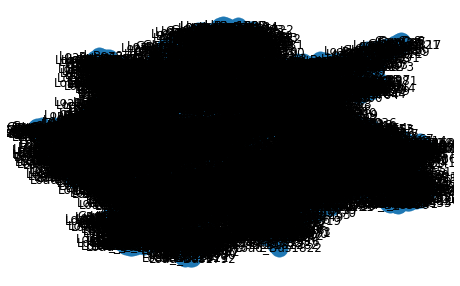

In [5]:
%matplotlib inline
case_network.draw()

In [8]:
case.branch_name

RangeIndex(start=0, stop=2531, step=1)

In [7]:
len(case.bus_name)


1888